In [2]:
import math
import random
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns

In [4]:
def Bern(p):
    if random.random()>p:
        return 0
    return 1

In [10]:
class eps_greedy():
    def __init__(self,eps,arms):
        self.eps=eps
        self.counts=[0 for i in range(arms)]
        self.vals=[0 for i in range(arms)]
        self.cumu_r=0
    #choose I(t)
    def choose_policy(self):
        #explore or exploitation
        if random.random() < self.eps:
            policy=random.randrange(arms)
        else:
            policy=self.vals.index(max(self.vals))
#         self.cumu_r+=self.vals[policy]
        return policy
    
    def update(self,policy,reward):
        #update count(I(t))
        self.counts[policy]+=1
        self.cumu_r+=reward[policy]
        #update theta_hat(I(t))
        cnt=self.counts[policy]
        val=self.vals[policy]
        self.vals[policy]+=(reward[policy]-val)/cnt
        return self.cumu_r,self.vals

In [7]:
class UCB():
    def __init__(self,arms,c,rewards):
        self.arms=arms
        self.c=c
        self.counts=[1 for i in range(arms)]
        self.vals=[rewards[i] for i in range(arms)]
        self.cumu_r=0
    def choose_policy(self,t):
        tmp=[]
        for i in range(arms):
            val=self.vals[i]+self.c*(math.sqrt(2*math.log(t)/self.counts[i]))
            tmp.append(val)
        policy=tmp.index(max(tmp))
#         self.cumu_r+=self.vals[policy]
        return policy
    def update(self,policy,reward):
        #update count(I(t))
        self.counts[policy]+=1
        self.cumu_r+=reward[policy]
        #update theta_hat(I(t))
        cnt=self.counts[policy]
        val=self.vals[policy]
        self.vals[policy]+=(reward[policy]-val)/cnt
        return self.cumu_r,self.vals

In [19]:
class thompson_sampling():
    def __init__(self,arms,alpha,beta):
        self.alpha=alpha
        self.beta=beta
        self.vals=[np.random.beta(self.alpha[i],self.beta[i]) for i in range(arms)]
        self.cumu_r=0
    def choose_policy(self):
        policy=self.vals.index(max(self.vals))
#         self.cumu_r+=self.vals[policy]
        return policy
    def update(self,policy,rewards):
        self.cumu_r+=rewards[policy]
        self.vals=[np.random.beta(self.alpha[i],self.beta[i]) for i in range(arms)]
        self.alpha[policy]+=rewards[policy]
        self.beta[policy]+=1-rewards[policy]
        return self.cumu_r,self.vals

In [23]:
class gradient():
    def __init__(self,alpha,arms,baseline):
        self.arms=arms
        self.H=np.zeros(arms)
        self.baseline=baseline
        self.alpha=alpha
        self.cumu_r=0
    def choose_policy(self,beta):
        #reflect preference for taking action
        exp=np.exp(beta*(self.H-np.max(self.H)))
        prob=exp/np.sum(exp)
        policy=np.random.choice(self.arms,p=prob)
#         self.cumu_r+=self.H[policy]
        return policy, prob
    def update(self,rewards,policy,prob):
        cur_r=rewards[policy]
        self.cumu_r+=cur_r
        r_avg=self.baseline
        #update H_{t+1}(a) when 1_{A_{t}=a}=1
        self.H[policy]+=self.alpha*(cur_r-r_avg)*(1-prob[policy])
        #when 1_{A_{t}=a}=0
        self.H[:policy]+=self.alpha*(cur_r-r_avg)*(0-prob[:policy])
        self.H[policy+1:]+=self.alpha*(cur_r-r_avg)*(0-prob[policy+1:])
        return self.cumu_r

In [11]:
############### Q4 ##################
def Bern_reward(arms):
    oracle_val=[0.9,0.8,0.7]
    return [Bern(oracle_val[i]) for i in range(arms)]
arms=3
N=5000
runTimes=1000

In [29]:
########### Q456-eps-greedy ############
eps=[0.1,0.5,0.9]
for i in range(len(eps)):
    time_regret=[[] for i in range(runTimes)]
    bestop_num=0
    runReward=[]
    for j in range(runTimes):
        algo=eps_greedy(eps[i],arms)
        arm1,arm2,arm3=[],[],[]
        for t in range(N):
            policy=algo.choose_policy()
            if policy==0:
                bestop_num+=1
            rewards=Bern_reward(arms)
            r,vals=algo.update(policy,rewards)
            time_regret[j].append(r)
#         print(r)
        runReward.append(r)
        arm1.append(vals[0])
        arm2.append(vals[1])
        arm3.append(vals[2])
    meanR=sum(runReward)/len(runReward)
    print('eps-greedy with eps=',eps[i])
    print('    mean reward over 1000 experiment is %.4f'%meanR)
    print('    arm1 value:%.4f'%(sum(arm1)/len(arm1)),'arm2 value:%.4f'%(sum(arm2)/len(arm2)),'arm3 value:%.4f'%(sum(arm3)/len(arm3)))
    print('    total regret accumulated over 1000 experiment is: %.4f'%(4500-meanR))
    print('    percentage of plays in which the optimal arm is pulled is %.2f'%(bestop_num/1000/50),'%\n')
    df=pd.DataFrame(time_regret)
    df.to_csv('eps{}_regret.csv'.format(eps[i]),index=0)

eps-greedy with eps= 0.1
    mean reward over 1000 experiment is 4443.2060
    arm1 value:0.8957 arm2 value:0.7870 arm3 value:0.6667
    total regret accumulated over 1000 experiment is: 56.7940
    percentage of plays in which the optimal arm is pulled is 92.49 %

eps-greedy with eps= 0.5
    mean reward over 1000 experiment is 4247.8800
    arm1 value:0.8971 arm2 value:0.7776 arm3 value:0.7226
    total regret accumulated over 1000 experiment is: 252.1200
    percentage of plays in which the optimal arm is pulled is 66.37 %

eps-greedy with eps= 0.9
    mean reward over 1000 experiment is 4048.1330
    arm1 value:0.9126 arm2 value:0.8005 arm3 value:0.6814
    total regret accumulated over 1000 experiment is: 451.8670
    percentage of plays in which the optimal arm is pulled is 39.92 %



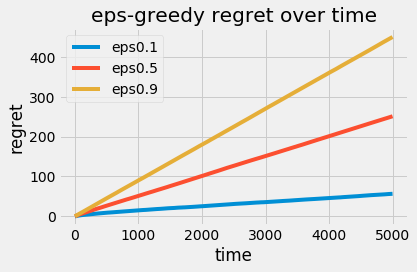

In [30]:
########### eps-greedy-img ############
df0=pd.DataFrame(pd.read_csv('eps0.1_regret.csv'))
df1=pd.DataFrame(pd.read_csv('eps0.5_regret.csv'))
df2=pd.DataFrame(pd.read_csv('eps0.9_regret.csv'))
# print(len(df0)) #1000
# print(len(df0.loc[0])) #5000
time=[i for i in range(5000)]
avg_regret0,avg_regret1,avg_regret2=[],[],[]
for t in range(5000):
    avg_regret0.append(0.9*t-sum(df0.iloc[:,t])/1000)
    avg_regret1.append(0.9*t-sum(df1.iloc[:,t])/1000)
    avg_regret2.append(0.9*t-sum(df2.iloc[:,t])/1000)
epsdf=pd.DataFrame({'avg_regret0':avg_regret0,'avg_regret1':avg_regret1,'avg_regret2':avg_regret2,'t':time})
sns.lineplot(x="t", y="avg_regret0",data=epsdf)
sns.lineplot(x="t", y="avg_regret1",data=epsdf)
sns.lineplot(x="t", y="avg_regret2",data=epsdf)
plt.title('eps-greedy regret over time')
plt.xlabel('time')
plt.ylabel('regret')
plt.legend(['eps0.1','eps0.5','eps0.9'])
plt.tight_layout()
plt.savefig('eps.jpg')
plt.show()

In [31]:
########### Q3-UCB ############
c=[1,5,10]
for i in range(len(c)):
    time_regret=[[] for i in range(runTimes)]
    bestop_num=0
    runReward=[]
    for j in range(runTimes):
        algo=UCB(arms,c[i],Bern_reward(arms))    
        arm1,arm2,arm3=[],[],[]
        for t in range(arms+1,N+1):
            policy=algo.choose_policy(t)
            if policy==0:
                bestop_num+=1
            rewards=Bern_reward(arms)
            r,vals=algo.update(policy,rewards)
            time_regret[j].append(r)
        runReward.append(r)
        arm1.append(vals[0])
        arm2.append(vals[1])
        arm3.append(vals[2])
    meanR=sum(runReward)/len(runReward)
    print('UCB with c=',c[i])
    print('    mean reward over 1000 experiment is %.4f'%meanR)
    print('    arm1 value:%.4f'%(sum(arm1)/len(arm1)),'arm2 value:%.4f'%(sum(arm2)/len(arm2)),'arm3 value:%.4f'%(sum(arm3)/len(arm3)))
    print('    total regret accumulated over 1000 experiment is: %.4f'%(4500-meanR))
    print('    percentage of plays in which the optimal arm is pulled is %.2f'%(bestop_num/1000/50),'%\n')
    df=pd.DataFrame(time_regret)
    df.to_csv('ucb{}_regret.csv'.format(c[i]),index=0)

UCB with c= 1
    mean reward over 1000 experiment is 4385.2170
    arm1 value:0.8923 arm2 value:0.8116 arm3 value:0.6867
    total regret accumulated over 1000 experiment is: 114.7830
    percentage of plays in which the optimal arm is pulled is 82.34 %

UCB with c= 5
    mean reward over 1000 experiment is 4124.6890
    arm1 value:0.8935 arm2 value:0.7937 arm3 value:0.6747
    total regret accumulated over 1000 experiment is: 375.3110
    percentage of plays in which the optimal arm is pulled is 47.21 %

UCB with c= 10
    mean reward over 1000 experiment is 4062.8740
    arm1 value:0.9062 arm2 value:0.7998 arm3 value:0.7098
    total regret accumulated over 1000 experiment is: 437.1260
    percentage of plays in which the optimal arm is pulled is 40.13 %



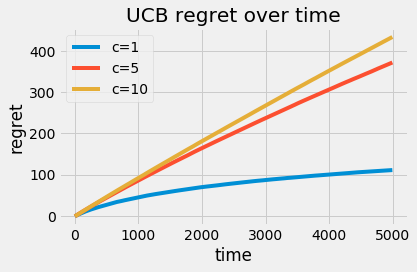

In [32]:
########### UCB-img ############
df0=pd.DataFrame(pd.read_csv('ucb1_regret.csv'))
df1=pd.DataFrame(pd.read_csv('ucb5_regret.csv'))
df2=pd.DataFrame(pd.read_csv('ucb10_regret.csv'))
# print(len(df0)) #1000
# print(len(df0.loc[0])) #4997
time=[i for i in range(4997)]
avg_regret0,avg_regret1,avg_regret2=[],[],[]
for t in range(4997):
    avg_regret0.append(0.9*t-sum(df0.iloc[:,t])/1000)
    avg_regret1.append(0.9*t-sum(df1.iloc[:,t])/1000)
    avg_regret2.append(0.9*t-sum(df2.iloc[:,t])/1000)
ucbdf=pd.DataFrame({'avg_regret0':avg_regret0,'avg_regret1':avg_regret1,'avg_regret2':avg_regret2,'t':time})
sns.lineplot(x="t", y="avg_regret0",data=ucbdf)
sns.lineplot(x="t", y="avg_regret1",data=ucbdf)
sns.lineplot(x="t", y="avg_regret2",data=ucbdf)
plt.title('UCB regret over time')
plt.xlabel('time')
plt.ylabel('regret')
plt.legend(['c=1','c=5','c=10'])
plt.tight_layout()
plt.savefig('ucb.jpg')
plt.show()

In [33]:
########### Q456-TS ############
a=[[1,1,1],[601,401,2]]
b=[[1,1,1],[401,601,3]]
alpha=[[1,1,1],[601,401,2]]
beta=[[1,1,1],[401,601,3]]
for i in range(len(alpha)):
    time_regret=[[] for i in range(runTimes)]
    bestop_num=0
    runReward=[]
    for j in range(runTimes):
        algo=thompson_sampling(arms,alpha[i],beta[i])
        arm1,arm2,arm3=[],[],[]
        for t in range(N):
            policy=algo.choose_policy()
            if policy==0:
                bestop_num+=1
            rewards=Bern_reward(arms)
            r,vals=algo.update(policy,rewards)
            time_regret[j].append(r)
        runReward.append(r)
        arm1.append(vals[0])
        arm2.append(vals[1])
        arm3.append(vals[2])
    meanR=sum(runReward)/len(runReward)
    print('Thompson sampling with alpha=',a[i],'beta=',b[i])
    print('    mean reward over 1000 experiment is %.4f'%meanR)
    print('    arm1 value:%.4f'%(sum(arm1)/len(arm1)),'arm2 value:%.4f'%(sum(arm2)/len(arm2)),'arm3 value:%.4f'%(sum(arm3)/len(arm3)))
    print('    total regret accumulated over 1000 experiment is: %.4f'%(4500-meanR))
    print('    percentage of plays in which the optimal arm is pulled is %.2f'%(bestop_num/1000/50),'%\n')
    df=pd.DataFrame(time_regret)
    df.to_csv('ts{}_regret.csv'.format(i),index=0)

Thompson sampling with alpha= [1, 1, 1] beta= [1, 1, 1]
    mean reward over 1000 experiment is 4499.8270
    arm1 value:0.8999 arm2 value:0.5785 arm3 value:0.7374
    total regret accumulated over 1000 experiment is: 0.1730
    percentage of plays in which the optimal arm is pulled is 100.00 %

Thompson sampling with alpha= [601, 401, 2] beta= [401, 601, 3]
    mean reward over 1000 experiment is 3500.6790
    arm1 value:0.5890 arm2 value:0.3831 arm3 value:0.6999
    total regret accumulated over 1000 experiment is: 999.3210
    percentage of plays in which the optimal arm is pulled is 0.00 %



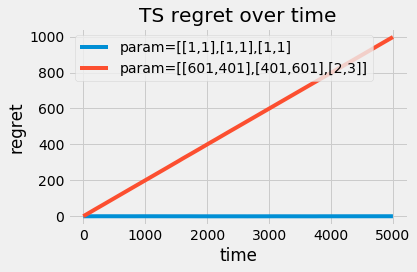

In [34]:
########### TS-img ############
df0=pd.DataFrame(pd.read_csv('ts0_regret.csv'))
df1=pd.DataFrame(pd.read_csv('ts1_regret.csv'))
# print(len(df0)) #1000
# print(len(df0.loc[0])) #5000
time=[i for i in range(5000)]
avg_regret0,avg_regret1=[],[]
for t in range(5000):
    avg_regret0.append(0.9*t-sum(df0.iloc[:,t])/1000)
    avg_regret1.append(0.9*t-sum(df1.iloc[:,t])/1000)
tsdf=pd.DataFrame({'avg_regret0':avg_regret0,'avg_regret1':avg_regret1,'t':time})
sns.lineplot(x="t", y="avg_regret0",data=tsdf)
sns.lineplot(x="t", y="avg_regret1",data=tsdf)
plt.title('TS regret over time')
plt.xlabel('time')
plt.ylabel('regret')
plt.legend(['param=[[1,1],[1,1],[1,1]','param=[[601,401],[401,601],[2,3]]'])
plt.tight_layout()
plt.savefig('TS.jpg')
plt.show()

In [35]:
########### Q3-baseline_Gradient ############
alpha=0.1
beta=1
b=[0,0.8,5,20]
for i in range(len(b)):
    time_regret=[[] for i in range(runTimes)]
    bestop_num=0
    runReward=[]
    for j in range(runTimes):
        algo=gradient(alpha,arms,b[i])
        for t in range(N):
            policy,prob=algo.choose_policy(beta)
            if policy==0:
                bestop_num+=1
            rewards=Bern_reward(arms)
            r =algo.update(rewards,policy,prob)
            time_regret[j].append(r)
#         print(r)
        runReward.append(r)
    meanR=sum(runReward)/len(runReward)
    print('baseline Gradient with baseline=',b[i])
    print('    mean reward over 1000 experiment is %.4f'%meanR)
    print('    total regret accumulated over 1000 experiment is: %.4f'%(4500-meanR))
    print('    percentage of plays in which the optimal arm is pulled is %.2f'%(bestop_num/1000/50),'%\n')
    df=pd.DataFrame(time_regret)
    df.to_csv('base_grad{}_regret.csv'.format(i),index=0)

baseline Gradient with baseline= 0
    mean reward over 1000 experiment is 4433.3090
    total regret accumulated over 1000 experiment is: 66.6910
    percentage of plays in which the optimal arm is pulled is 89.42 %

baseline Gradient with baseline= 0.8
    mean reward over 1000 experiment is 4450.3930
    total regret accumulated over 1000 experiment is: 49.6070
    percentage of plays in which the optimal arm is pulled is 92.57 %

baseline Gradient with baseline= 5
    mean reward over 1000 experiment is 4102.3540
    total regret accumulated over 1000 experiment is: 397.6460
    percentage of plays in which the optimal arm is pulled is 43.39 %

baseline Gradient with baseline= 20
    mean reward over 1000 experiment is 3996.3010
    total regret accumulated over 1000 experiment is: 503.6990
    percentage of plays in which the optimal arm is pulled is 34.84 %



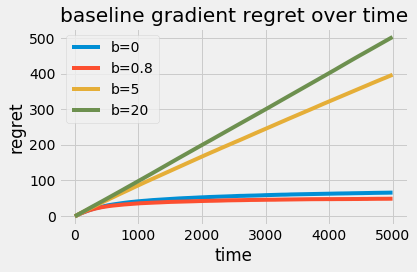

In [36]:
########### baseline_gradient-img ############
df0=pd.DataFrame(pd.read_csv('base_grad0_regret.csv'))
df1=pd.DataFrame(pd.read_csv('base_grad1_regret.csv'))
df2=pd.DataFrame(pd.read_csv('base_grad2_regret.csv'))
df3=pd.DataFrame(pd.read_csv('base_grad3_regret.csv'))
# print(len(df0)) #1000
# print(len(df0.loc[0])) #5000
time=[i for i in range(5000)]
avg_regret0,avg_regret1,avg_regret2,avg_regret3=[],[],[],[]
for t in range(5000):
    avg_regret0.append(0.9*t-sum(df0.iloc[:,t])/1000)
    avg_regret1.append(0.9*t-sum(df1.iloc[:,t])/1000)
    avg_regret2.append(0.9*t-sum(df2.iloc[:,t])/1000)
    avg_regret3.append(0.9*t-sum(df3.iloc[:,t])/1000)
base_grad_df=pd.DataFrame({'avg_regret0':avg_regret0,'avg_regret1':avg_regret1,'avg_regret2':avg_regret2,'avg_regret3':avg_regret3,'t':time})
sns.lineplot(x="t", y="avg_regret0",data=base_grad_df)
sns.lineplot(x="t", y="avg_regret1",data=base_grad_df)
sns.lineplot(x="t", y="avg_regret2",data=base_grad_df)
sns.lineplot(x="t", y="avg_regret3",data=base_grad_df)
plt.title('baseline gradient regret over time')
plt.xlabel('time')
plt.ylabel('regret')
plt.legend(['b=0','b=0.8','b=5','b=20'])
plt.tight_layout()
plt.savefig('base_grad.jpg')
plt.show()

In [41]:
########### Q3-parameterized_Gradient ############
alpha=0.1
beta=[0.2,1,2,5]
for i in range(len(beta)):
    time_regret=[[] for i in range(runTimes)]
    bestop_num=0
    runReward=[]
    for j in range(runTimes):
        #set baseline to be zero
        algo=gradient(alpha,arms,0)
        for t in range(N):
            policy,prob=algo.choose_policy(beta[i])
            if policy==0:
                bestop_num+=1
            rewards=Bern_reward(arms)
            r =algo.update(rewards,policy,prob)
            time_regret[j].append(r)
#         print(r)
        runReward.append(r)
    meanR=sum(runReward)/len(runReward)
    print('parameterized Gradient with beta=',beta[i])
    print('    mean reward over 1000 experiment is %.4f'%meanR)
    print('    total regret accumulated over 1000 experiment is: %.4f'%(4500-meanR))
    print('    percentage of plays in which the optimal arm is pulled is %.2f'%(bestop_num/1000/50),'%\n')
    df=pd.DataFrame(time_regret)
    df.to_csv('param_grad{}_regret.csv'.format(i),index=0)

parameterized Gradient with beta= 0.2
    mean reward over 1000 experiment is 4320.4330
    total regret accumulated over 1000 experiment is: 179.5670
    percentage of plays in which the optimal arm is pulled is 74.10 %

parameterized Gradient with beta= 1
    mean reward over 1000 experiment is 4424.6750
    total regret accumulated over 1000 experiment is: 75.3250
    percentage of plays in which the optimal arm is pulled is 88.12 %

parameterized Gradient with beta= 2
    mean reward over 1000 experiment is 4420.0120
    total regret accumulated over 1000 experiment is: 79.9880
    percentage of plays in which the optimal arm is pulled is 86.34 %

parameterized Gradient with beta= 5
    mean reward over 1000 experiment is 4352.7510
    total regret accumulated over 1000 experiment is: 147.2490
    percentage of plays in which the optimal arm is pulled is 74.52 %



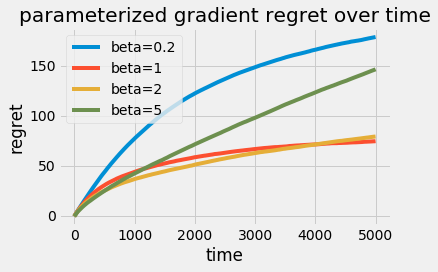

In [42]:
########### param_gradient-img ############
df0=pd.DataFrame(pd.read_csv('param_grad0_regret.csv'))
df1=pd.DataFrame(pd.read_csv('param_grad1_regret.csv'))
df2=pd.DataFrame(pd.read_csv('param_grad2_regret.csv'))
df3=pd.DataFrame(pd.read_csv('param_grad3_regret.csv'))
# print(len(df0)) #1000
# print(len(df0.loc[0])) #5000
time=[i for i in range(5000)]
avg_regret0,avg_regret1,avg_regret2,avg_regret3=[],[],[],[]
for t in range(5000):
    avg_regret0.append(0.9*t-sum(df0.iloc[:,t])/1000)
    avg_regret1.append(0.9*t-sum(df1.iloc[:,t])/1000)
    avg_regret2.append(0.9*t-sum(df2.iloc[:,t])/1000)
    avg_regret3.append(0.9*t-sum(df3.iloc[:,t])/1000)
base_grad_df=pd.DataFrame({'avg_regret0':avg_regret0,'avg_regret1':avg_regret1,'avg_regret2':avg_regret2,'avg_regret3':avg_regret3,'t':time})
sns.lineplot(x="t", y="avg_regret0",data=base_grad_df)
sns.lineplot(x="t", y="avg_regret1",data=base_grad_df)
sns.lineplot(x="t", y="avg_regret2",data=base_grad_df)
sns.lineplot(x="t", y="avg_regret3",data=base_grad_df)
plt.title('parameterized gradient regret over time')
plt.xlabel('time')
plt.ylabel('regret')
plt.legend(['beta=0.2','beta=1','beta=2','beta=5'])
plt.tight_layout()
plt.savefig('param_grad.jpg')
plt.show()

In [39]:
########### Q3-time_varying_Gradient ############
alpha=0.1
time_regret=[[] for i in range(runTimes)]
bestop_num=0
runReward=[]
for j in range(runTimes):
    #set baseline to be zero
    algo=gradient(alpha,arms,0)
    for t in range(1,N+1):
        beta=10/math.log(t+1.1)
        policy,prob=algo.choose_policy(beta)
        if policy==0:
                bestop_num+=1
        rewards=Bern_reward(arms)
        r =algo.update(rewards,policy,prob)
        time_regret[j].append(r)
    runReward.append(r)
meanR=sum(runReward)/len(runReward)
print('time varying Gradient with beta=10/log(t+1.1)')
print('    mean reward over 1000 experiment is %.4f'%meanR)
print('    total regret accumulated over 1000 experiment is: %.4f'%(4500-meanR))
print('    percentage of plays in which the optimal arm is pulled is %.2f'%(bestop_num/1000/50),'%\n')
df=pd.DataFrame(time_regret)
df.to_csv('time_grad_regret.csv',index=0)

time varying Gradient with beta=10/log(t+1.1)
    mean reward over 1000 experiment is 4421.8370
    total regret accumulated over 1000 experiment is: 78.1630
    percentage of plays in which the optimal arm is pulled is 87.10 %



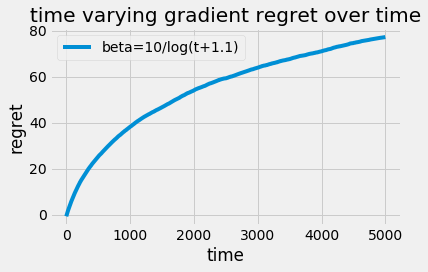

In [40]:
########### time_varying_gradient-img ############
df0=pd.DataFrame(pd.read_csv('time_grad_regret.csv'))
# print(len(df0)) #1000
# print(len(df0.loc[0])) #5000
time=[i for i in range(5000)]
avg_regret=[]
for t in range(5000):
    avg_regret.append(0.9*t-sum(df0.iloc[:,t])/1000)
base_grad_df=pd.DataFrame({'avg_regret':avg_regret,'t':time})
sns.lineplot(x="t", y="avg_regret",data=base_grad_df)
plt.title('time varying gradient regret over time')
plt.xlabel('time')
plt.ylabel('regret')
plt.legend(['beta=10/log(t+1.1)'])
plt.tight_layout()
plt.savefig('time_grad.jpg')
plt.show()

In [1]:
########### Q8-dependent-arms ############
class dependent_arm():
    def __init__(self,clusters,eps):
        self.clusters=clusters
        self.eps=eps
        self.cnum=len(clusters)
        self.success=[0 for i in range(self.cnum)]
        self.fail=[0 for i in range(self.cnum)]
        self.counts=[0 for i in range(self.cnum)]
        self.vals=[0 for i in range(self.cnum)]
        self.cumu_r=0
    #choose I(t)
    def choose_cluster(self):
        #explore or exploitation
        if random.random() < self.eps:
            cluster=random.randrange(self.cnum)
        else:
            cluster=self.vals.index(max(self.vals))
        return cluster
    
    def update(self,cluster,cur_r):
        #update count(I(t))
        self.counts[cluster]+=1
        self.cumu_r+=cur_r
        #update theta_hat(I(t))
        cnt=self.counts[cluster]
        val=self.vals[cluster]
        self.vals[cluster]+=(cur_r-val)/cnt
        return self.cumu_r,self.vals

In [11]:
arms=3
N = 5000
runTimes=1000
# set oracle value
clusters = [[0.9, 0.8,0.7], [0.8, 0.75, 0.5], [0.75, 0.7, 0.65]]

time_regret=[[] for i in range(runTimes)]
bestcluster_num=0
bestarm_num=0
TotalReward=[]
for k in range(runTimes):
    rewards=[]
    for i in range(3):
        rewards.append([Bern(clusters[i][j]) for j in range(3)])
    fir_algo=dependent_arm(clusters,0.1)
    sec_algo=[UCB(3,1,rewards[i]) for i in range(3)]
    for t in range(1,N+1):
        cluster=fir_algo.choose_cluster()
        policy=sec_algo[cluster].choose_policy(t)
        if cluster==0:
            bestcluster_num+=1
            if policy==0:
                bestarm_num+=1
        reward=[Bern(clusters[cluster][i]) for i in range(3)]
        cur_r=reward[policy]
        sec_algo[cluster].update(policy,reward)
        cumu_r,vals=fir_algo.update(cluster,cur_r)
        time_regret[k].append(cumu_r)
    TotalReward.append(cumu_r)
meanR=sum(TotalReward)/1000
# print(sum(TotalReward)/1000)
# print(vals)
# print(bestcluster_num/50/runTimes,'%   ',bestarm_num/50/runTimes,'%')
print('Denpendent arm two-level policy with eps=0.1,c=1')
print('    mean reward over 1000 experiment is %.4f'%meanR)
print('    cluster1 value:%.4f'%vals[0],'cluster2 value:%.4f'%vals[1],'cluster3 value:%.4f'%vals[2])
print('    total regret accumulated over 1000 experiment is: %.4f'%(4500-meanR))
print('    percentage of plays in which the optimal cluster is pulled is %.2f'%(bestcluster_num/1000/50),'%')
print('    percentage of plays in which the optimal arm is pulled is %.2f'%(bestarm_num/1000/50),'%\n')
df=pd.DataFrame(time_regret)
df.to_csv('deparm_regret.csv',index=0)

Denpendent arm two-level policy with eps=0.1,c=1
    mean reward over 1000 experiment is 4314.7690
    cluster1 value:0.8792 cluster2 value:0.7612 cluster3 value:0.7193
    total regret accumulated over 1000 experiment is: 185.2310
    percentage of plays in which the optimal cluster is pulled is 90.68 %
    percentage of plays in which the optimal arm is pulled is 73.95 %



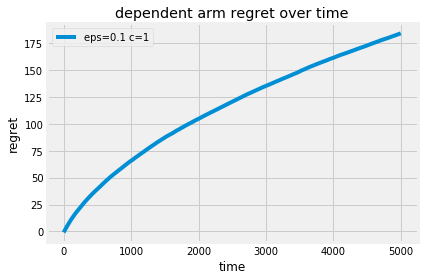

In [12]:
########### dependent arm -img ############
df0=pd.DataFrame(pd.read_csv('deparm_regret.csv'))
# print(len(df0)) #1000
# print(len(df0.loc[0])) #5000
time=[i for i in range(5000)]
avg_regret=[]
for t in range(5000):
    avg_regret.append(0.9*t-sum(df0.iloc[:,t])/1000)
base_grad_df=pd.DataFrame({'avg_regret':avg_regret,'t':time})
sns.lineplot(x="t", y="avg_regret",data=base_grad_df)
plt.title('dependent arm regret over time')
plt.xlabel('time')
plt.ylabel('regret')
plt.legend(['eps=0.1 c=1'])
plt.tight_layout()
plt.savefig('dep_arm.jpg')
plt.show()